## Showcasing the options for utilizing the parameterized - local basis optimization (pLBO).
### Overview:
- Learning the local basis:
    - with the method used in the paper as present in the "DataGeneration.py" file.
    - using BFGS.
    - Both are compared to the result when doing no local basis optimization.
- Put together with standard LBO techniques.
- Transforming from the local basis to the original Fock basis.
    - by utilizing StrawberryFields
    - by diagonalization.

### Importing the relevant modules:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from script import * #script.py contains functions related to the parameterized Local Basis Optimization techniques.
from script import _print #is a helpful function for also printing the time.
import thewalrus as tw #for generating covariance matrices of Gaussian states.
import torch #is the underlying library for the autograd functionality.
import copy #is useful for obtaining a copy instead of a view of the data of an object.
from tqdm import tqdm
import scipy as sp

/home/vinther/.venv/lib/python3.10/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


### Defining the problem setting:

In [2]:
N = 5 #Number of modes
D = 6 #Basis cutoff
seed = 13 #Seed for random number generator
kappa = 1.0 #Strength of the non-Gaussian gate

verbose = False #If True, prints the results of the optimization at each step.

np.random.seed(seed)
cov = tw.random.random_covariance(N, pure=True)

In [3]:
pdict = {
    "D": D,
    "N": N,
    'basis': 'local', #either local or standard. Determines whether the local basis is learned or not.
    "dtype": torch.cfloat, #cfloat is much faster than cdouble when using autograd.
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "max bond dim": D, #or "bond dimensions" [list]: The maximum bond dimension of the MPS or a list of bond dimensions for each site.
    "kappa": kappa,
    "covariance matrix": cov, #The covariance matrix that defines the Gaussian Boson Sampling problem.
}

trainer = TrainingModule(pdict)

18:32:25 - Learnable parameters are: ['alpha', 'r', 'phi', 'theta', 's', 'gamma', 'kappa']


## Parameterized Local Basis Optimization:

### The piece of code below optimizes the variational state according to the procedure utilized in the paper which is also present in the file "DataGeneration.py"

It consists of:
- First run dmrg from a bond-dimension of 1 -> D
- Then optimize the local basis via stochastic gradient descent
- after convergence, run drmg in the optimized local basis, increasing the bond dimension from D to the wanted bond dimension.

18:32:31 - Temporary state created for trainer
18:32:43 - optimizing basis parameters
At step:  0


[W105 18:32:43.786347292 Copy.cpp:308] Warning: Casting complex values to real discards the imaginary part (function operator())


At step:  1
At step:  2
At step:  3
At step:  4
At step:  5
At step:  6
At step:  7
At step:  8
At step:  9
18:33:12 - Running DMRG in the optimized basis
Without pLBO: 5.418567657470703
With pLBO: 3.643354654312134


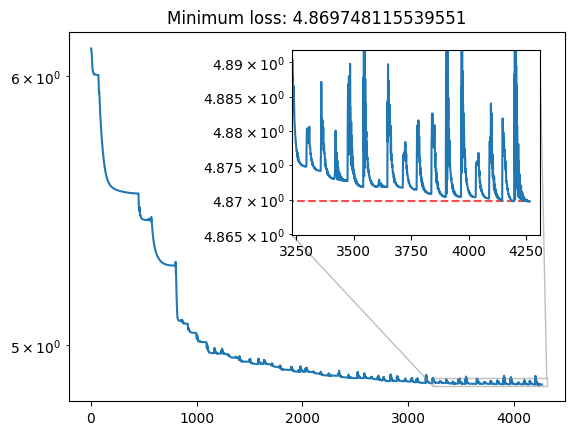

In [4]:
bond_dims = [i for i in range(1,D)]+[int(i) for i in np.linspace(D,D**2,6)]

def get_MPO_from_trainer(trainer):
    trainer._initialize_MPOs()
    MPO = trainer.MPOs[0] * trainer.prefactors[0]
    for i in range(1,len(trainer.MPOs)):
        MPO += trainer.MPOs[i] * trainer.prefactors[i]
    MPO = copy.copy(MPO)
    MPO.apply_to_arrays(lambda x: x.detach().cpu().numpy())
    return MPO

def plot_losses(losses):
    fig, ax = plt.subplots()
    ax.plot(losses)
    ax.set_yscale("log")

    # Create inset axes
    axins = ax.inset_axes([0.45, 0.45, 0.5, 0.5])  # [left, bottom, width, height]

    # Plot the zoomed-in data
    axins.plot(losses)
    axins.hlines(losses[-1], 0, len(losses), alpha=0.7, color='r', ls="--",zorder=-1, label="ADAM")
    axins.set_yscale("log")

    # Set the limits of the inset axes
    ulim = np.quantile(losses,0.4)
    axins.set_ylim(min(losses)*(1-1e-3),ulim)
    axins.set_xlim(np.argmin(np.abs(np.array(losses)-ulim)),len(losses)*1.01)
    ax.indicate_inset_zoom(axins)
    ax.set_title(f"Minimum loss: {min(losses)}")
    return fig

MPO_nonLBO = get_MPO_from_trainer(trainer)
dmrg = qtn.DMRG1(MPO_nonLBO, bond_dims=bond_dims)
dmrg.opts["local_eig_backend"] = "LOBPCG"
with warnings.catch_warnings():
    warnings.filterwarnings(action='ignore')
    dmrg.solve(verbosity=verbose,max_sweeps=D, tol = 0)
tmpstate = copy.deepcopy(dmrg.state)
tmpstate.apply_to_arrays(lambda x: torch.tensor(x, dtype=pdict["dtype"]))

_print("Temporary state created for trainer")
with warnings.catch_warnings():
    warnings.filterwarnings(action='ignore')
    dmrg.solve(verbosity=verbose,max_sweeps=15)
MPS_nonLBO = dmrg.state

_print("optimizing basis parameters")
trainer.lr = 1
trainer.losses.append(np.inf)
trainer.MPS = tmpstate
trainer.learn_run(verbose=verbose)
fig = plot_losses(trainer.losses)

_print("Running DMRG in the optimized basis")
MPO_pLBO = get_MPO_from_trainer(trainer)
p0 = trainer.MPS
p0.apply_to_arrays(lambda x: x.detach().cpu().numpy())
dmrgpLBO = qtn.DMRG1(MPO_pLBO, bond_dims=bond_dims[D:],p0=p0)
dmrgpLBO.opts["local_eig_backend"] = "LOBPCG"
with warnings.catch_warnings():
    warnings.filterwarnings(action='ignore')
    dmrgpLBO.solve(verbosity=verbose,max_sweeps=7+15)

print("Without pLBO:",dmrg.energies[-1].real)
print("With pLBO:",dmrgpLBO.energies[-1].real)

### BFGS

An alternative, which is also okay, but usually obtains a less optimal result, is using BFGS instead of stochastic gradient descent. Because this method requires less iterations, we can choose to perform the local basis optimization at the ultimate bond dimension.

18:33:17 - Learnable parameters are: ['alpha', 'r', 'phi', 'theta', 's', 'gamma', 'kappa']
18:33:17 - Initial MPS prepared: Seeded the random MPS with the given max bond dimension
At step:  0
At step:  1
At step:  2
At step:  3
At step:  4
At step:  5
At step:  6
At step:  7
At step:  8
At step:  9
At step:  10
At step:  11
At step:  12
At step:  13
At step:  14
At step:  15
At step:  16
At step:  17
At step:  18
At step:  19
At step:  20
At step:  21
At step:  22
At step:  23
At step:  24
At step:  25
At step:  26
At step:  27
At step:  28
At step:  29


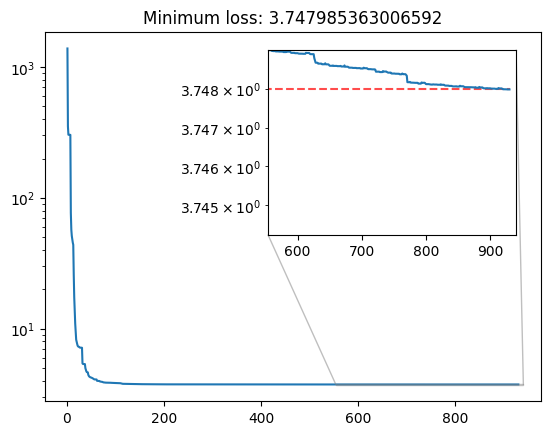

In [5]:
pdict["max bond dim"] = D**2
trainer_BFGS = TrainingModule(pdict)

trainer_BFGS._local_update = trainer_BFGS._local_update_BFGS
trainer_BFGS._initialize_MPS()
trainer_BFGS._initialize_MPOs()

trainer_BFGS.lr = 0.01
trainer_BFGS.tol = 1e-7
trainer_BFGS.LBFGS_max_iter = 20
trainer_BFGS.max_iter = 6
trainer_BFGS.tolerance_change = 1e-9
trainer_BFGS.tolerance_grad = 1e-7
trainer_BFGS.sweep(verbose=verbose)
minloss = trainer_BFGS.losses[-1]
for _ in range(30):
    print("\nAt step: ",_) if verbose else print("At step: ",_)
    trainer_BFGS.sweep(verbose=verbose)
    if minloss > trainer_BFGS.losses[-1] > 0.95*minloss:
        break
    
fig = plot_losses(trainer_BFGS.losses)

## Standard LBO techniques:

We can compare the above gradient based optimization methods for pLBO to the eigensolver based methods for standard LBO techniques.

Specifically we present rudimentary code that implements the optimization procedure encapsulated by fig. 10 in the paper.
We enlarge the physical dimension via isometries contained in the list 'Ds'. We then optimize these variationally, going from one site to the next in a sweeping manner. More efficient methods would perhaps iterate between updating the local basis and the MPS cores, but that is not done here.

In [6]:
def standardLBO(psi, basis_params = None, capD = 100, verbose = False):
    ####### Simple way of constructing the MPOs with the large cutoff.
    pdict["D"] = capD #The new cutoff for the local basis. Defines the isometries as capD x D matrices.
    MPOCreator = TrainingModule(pdict)
    pdict["D"] = D
    #######
    if basis_params is not None:
        MPOCreator.basis_params = basis_params
    MPOCreator._initialize_MPOs()
    
    capDD = np.zeros((capD,D),dtype=np.complex64)
    capDD[:D,:D] = np.eye(D) #Initialize the isometries as identities.
    Ds = [capDD]*N
    def construct_MPOs_from_Ds_at_n(Ds,n):
        MPOs = []
        constructors = [MPOCreator.construct_MPO_cores(_) for _ in range(N)]
        for const in range(len(constructors[0])):
            cores = []
            for i in range(N):
                X, P = MPOCreator._get_XandP({key: MPOCreator.basis_params[key][i] for key in MPOCreator.basis_params.keys()})
                if i != n:
                    cores.append(Ds[i].T.conj()@constructors[i][const](X,P).detach().cpu().numpy()@Ds[i])
                else:
                    cores.append(constructors[i][const](X,P).detach().cpu().numpy())
            MPO = qtn.MatrixProductOperator(cores)
            MPO = MPO.reindex({"k"+str(i):"bt"+str(i) for i in range(N)})
            MPO = MPO.reindex({"b"+str(i):"k"+str(i) for i in range(N)})
            MPO = MPO.reindex({"bt"+str(i):"b"+str(i) for i in range(N)})
            MPOs.append(MPO)
        return MPOs
    reindices = {"k"+str(i):"b"+str(i) for i in range(N)}
    reindices.update({"d"+str(i):"dp"+str(i) for i in range(N)})

    def optimize_Ds(Ds, psi):
        '''
        Optimization of the isometries. The optimization is done by constructing the effective Hamiltonian and selecting the lowest lying eigenstate.
        '''
        # Optimization loop. Can be run multiple times, but it only optimizes the isometry at each site, not the MPS cores.
        for n in tqdm(range(N), disable=~verbose):
            #State with enlarged basis, with the proper orthogonality center for sweeping left to right.
            state = (qtn.TensorNetwork([qtn.Tensor(Ds[i],inds=[f'k{i}',f'd{i}'],tags=f"D{i}") for i in range(N)])|psi.reindex({"k"+str(i):"d"+str(i) for i in range(N)})).canonize_around(f"D{n}")
            
            #from this collect the isometries and the MPS, but now with the proper gauge. (all of this can be done more efficiently)
            Ds = [state[f"D{i}"].to_qarray((f"k{i}",f"d{i}")).reshape(capD,D) for i in range(N)]
            psi = qtn.MatrixProductState.from_TN(state.select_all((f"I{i}" for i in range(N)),which="any").reindex({"d"+str(i):"k"+str(i) for i in range(N)}).reindex({"k"+str(n):"d"+str(n)}),psi)
            ham = construct_MPOs_from_Ds_at_n(Ds,n)
            
            #Construct the effective Hamiltonian. See e.g. fig. 10 in the paper.
            EffHam = MPOCreator.prefactors[0]*(psi.H.reindex(reindices)|ham[0]|psi).contract(all).to_qarray((f"b{n}",f"dp{n}",f"k{n}",f"d{n}"))
            for i_ham in range(1,len(ham)):
                EffHam += MPOCreator.prefactors[i_ham]*(psi.H.reindex(reindices)|ham[i_ham]|psi).contract(all).to_qarray((f"b{n}",f"dp{n}",f"k{n}",f"d{n}"))
            
            #Variational optimization of the isometry.
            eigval, eigvec = sp.linalg.eigh(EffHam.reshape(D*capD,D*capD), subset_by_index=(0,0))
            
            #Update the isometry.
            Ds[n] = eigvec.reshape(capD,D)
            print(n, eigval, state.H@state) if verbose else None #print site index, eigenvalue, and the norm of the state (should remain normalized due to the shifts in orthogonality center).
        state = (qtn.TensorNetwork([qtn.Tensor(Ds[i],inds=[f'k{i}',f'd{i}'],tags=f"D{i}") for i in range(N)])|psi.reindex({"k"+str(i):"d"+str(i) for i in range(N)})).canonize_around(f"I{n}")
        Ds = [state[f"D{i}"].to_qarray((f"k{i}",f"d{i}")).reshape(capD,D) for i in range(N)]
        psi = qtn.MatrixProductState.from_TN(state.select_all((f"I{i}" for i in range(N)),which="any").reindex({"d"+str(i):"k"+str(i) for i in range(N)}).reindex({"k"+str(n):"d"+str(n)}),psi)
        return Ds, psi
    
    def optimize_MPS(Ds, psi):
        '''
        Optimization of the MPS cores by DMRG.
        '''
        MPOs = construct_MPOs_from_Ds_at_n(Ds,None)
        MPO = MPOs[0] * MPOCreator.prefactors[0]
        for i in range(1,len(MPOCreator.MPOs)):
            MPO += MPOs[i] * MPOCreator.prefactors[i]

        dmrg = qtn.DMRG1(MPO, bond_dims=bond_dims[-1],p0 = psi.reindex({f"d{N-1}":f"k{N-1}"}))
        dmrg.opts["local_eig_backend"] = "lobpcg"
        dmrg.solve(verbosity=verbose,max_sweeps=15)
        return dmrg.state, dmrg.energy
    
    #Loop between optimizing the isometries and the MPS cores.
    #It is probably better to iterate over both the isometry and the MPS core at one site before moving to the next site.
    for _ in range(5):
        Ds, psi = optimize_Ds(Ds, psi)
        psi, E = optimize_MPS(Ds, psi)
        print("Step: ",_," Energy: ",E)

    return Ds, psi, E

18:34:26 - Learnable parameters are: ['alpha', 'r', 'phi', 'theta', 's', 'gamma', 'kappa']
Step:  0  Energy:  (3.77228045463562-2.0265579223632812e-06j)
Step:  1  Energy:  (3.578826665878296+2.0265579223632812e-06j)
Step:  2  Energy:  (3.5203278064727783-2.562999725341797e-06j)
Step:  3  Energy:  (3.497708320617676-1.430511474609375e-06j)
Step:  4  Energy:  (3.488029956817627+1.3113021850585938e-06j)
18:34:52 - Learnable parameters are: ['alpha', 'r', 'phi', 'theta', 's', 'gamma', 'kappa']
Step:  0  Energy:  (3.500699520111084-1.6689300537109375e-06j)
Step:  1  Energy:  (3.4871606826782227+2.6226043701171875e-06j)
Step:  2  Energy:  (3.483116626739502-4.76837158203125e-07j)
Step:  3  Energy:  (3.4814059734344482+2.2649765014648438e-06j)
Step:  4  Energy:  (3.480617046356201-1.9073486328125e-06j)
18:35:14 - Learnable parameters are: ['alpha', 'r', 'phi', 'theta', 's', 'gamma', 'kappa']
Step:  0  Energy:  (3.549647808074951-2.7865171432495117e-06j)
Step:  1  Energy:  (3.5108747482299805-

[Text(0, 0, 'DMRG'), Text(1, 0, 'pLBO'), Text(2, 0, 'BFGS')]

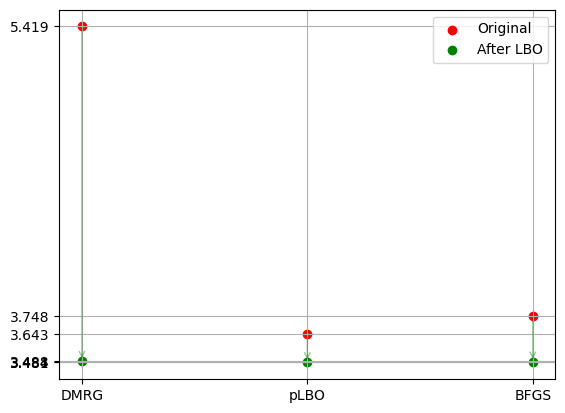

In [7]:
Dlist = []
Es = []

psiBFGS = trainer_BFGS.MPS
psiBFGS.apply_to_arrays(lambda x: x.detach().cpu().numpy())
for psi, basis_params in zip([dmrg.state,dmrgpLBO.state,psiBFGS],[None,trainer.basis_params,trainer_BFGS.basis_params]):
    Ds, _, E = standardLBO(copy.deepcopy(psi), basis_params = basis_params, capD = 100)
    Dlist.append(Ds)
    Es.append(E)

#Plotting the results.
newEs = [E.real for E in Es]
oldEs = [dmrg.energies[-1].real,dmrgpLBO.energies[-1].real,trainer_BFGS.losses[-1]]

fig, ax = plt.subplots()

for i, newE, oldE in zip([0,1,2],newEs,oldEs):
    ax.annotate("", xy=(i, oldE), xytext=(i, newE), 
                arrowprops=dict(arrowstyle="<-",alpha=0.4,color="g"))
    ax.scatter([i],[newE],color="g")
    ax.scatter([i],[oldE],color="r")

ax.scatter([None],[None],label=f"Original",color="r")
ax.scatter([None],[None],label=f"After LBO",color="g")
ax.legend()
ax.set_yticks(newEs+oldEs)
plt.grid()
ax.set_xticks([0,1,2])
ax.set_xticklabels(["DMRG","pLBO","BFGS"])

All three methods obtained the same minimum for the current setup. That is because the learned basis for pLBO and BFGS does not contain anything that can't be described by the 100 lowest lying states of simple quantum harmonic oscillator. This would not be the case if e.g. the optimal basis contains a large displacement or similar. This could be captured easily by the pLBO and not directly by the LBO and in this sense these two methods may complement eachother.
The next step would be to optimize both at the same time, but that remains for further work.

## Recovering amplitudes in the original basis:

Considering an implicit basis defined by the dictionary 'basis_params', we would like to recover the basis transformation that places the amplitudes back in the fock basis.

This can be done by at least two methods:
- using the python module StrawberryFields for Continuous variable systems simulation.
- or diagonalization of a known operator such as e.g. $\hat{a}^\dagger\hat{a}$.

Seemingly, the simulation due to strawberryfields could be approximate because of the non-Gaussian gates https://strawberryfields.readthedocs.io/en/stable/code/api/strawberryfields.ops.Vgate.html. Therefore, diagonalization seems like a viable approach except that it is damaged by the necessarily finite cutoff. Nonetheless, to see which eigenstates have an error we simply have to consider their eigenvalue.

18:35:35 - Learnable parameters are: ['alpha', 'r', 'phi', 'theta', 's', 'gamma', 'kappa']


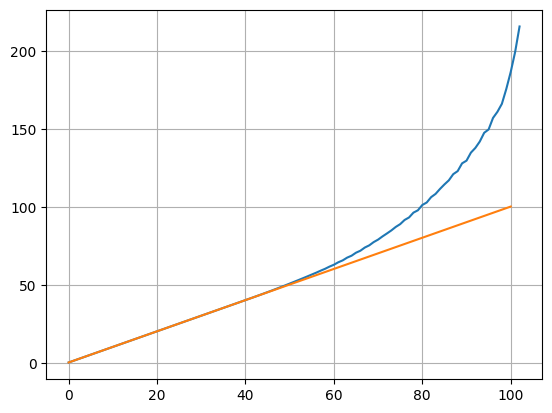

In [8]:
####### Simple way of constructing the MPOs with the large cutoff.
pdict["D"] = 100 #The new cutoff for the local basis. Defines the isometries as capD x D matrices.
XPCreator = TrainingModule(pdict)
pdict["D"] = D
#######
if basis_params is not None:
    XPCreator.basis_params = trainer.basis_params
XPCreator._initialize_MPOs()

X, P = XPCreator._get_XandP({key: XPCreator.basis_params[key][0] for key in XPCreator.basis_params.keys()})
nhat = 0.5*(X@X + P@P)[:-1,:-1]
nhat_eigs = np.linalg.eigh(nhat)
plt.plot(nhat_eigs.eigenvalues)
plt.plot([0,100],[0.5,100+0.5])
plt.grid()

At this cutoff, the "simulation by diagonalization" will be correct until the ~50th state. We can now compare this to the simulation by strawberryfields:

In [9]:
d = 100
import strawberryfields as sf
def new_basis(basis_params,Dout=100):
    integrals_mat = np.zeros((Dout,d),dtype=np.complex128)
    for n in range(d):
        prog = sf.Program(1)
        with prog.context as q:
            sf.ops.Fock(n) | q[0]
            sf.ops.Kgate(basis_params["kappa"]) | q[0]
            sf.ops.Vgate(basis_params["gamma"]) | q[0]
            sf.ops.Pgate(basis_params["s"]) | q[0]
            sf.ops.Rgate(basis_params["theta"]) | q[0]
            sf.ops.Sgate(basis_params["r"],basis_params["phi"]) | q[0]
            sf.ops.Dgate(np.abs(basis_params["alpha"]),np.angle(basis_params["alpha"])) | q[0]

        eng = sf.Engine("fock", backend_options={"cutoff_dim": Dout})
        result = eng.run(prog)
        integrals_mat[:,n] = result.state.ket()
    return integrals_mat

U_sf = new_basis({key: trainer.basis_params[key][0].item() for key in trainer.basis_params.keys()},100)

/tmp/ipykernel_298754/2046195121.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
/tmp/ipykernel_298754/2046195121.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)


Text(0.5, 0, 'Difference')

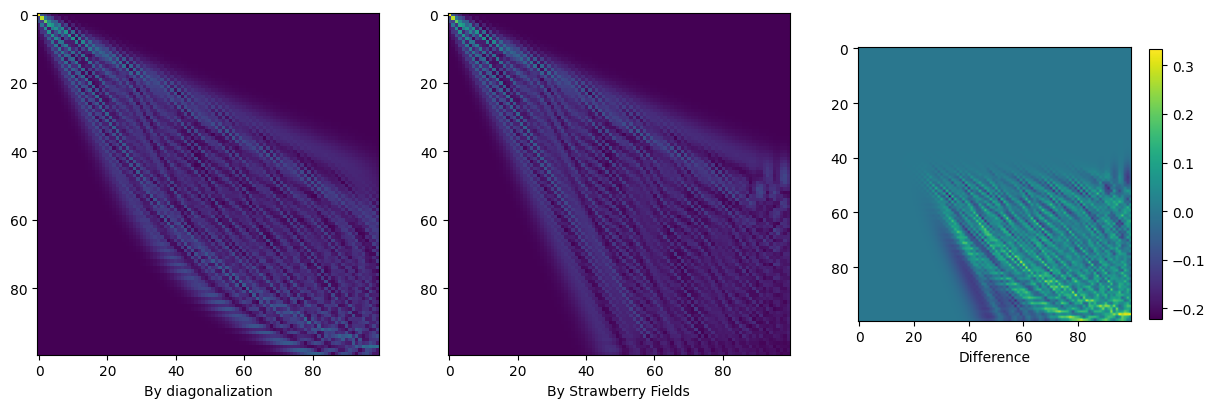

In [10]:
fig, ax = plt.subplots(ncols=3,figsize=(15,5))
ax[0].imshow(np.abs(nhat_eigs.eigenvectors.T[:d,:d]))
ax[1].imshow(np.abs(U_sf)[:d,:d])
ax[2].imshow(np.abs(nhat_eigs.eigenvectors.T[:d,:d]) - np.abs(U_sf)[:d,:d])
fig.colorbar(ax[2].images[0], ax=ax[2], shrink=0.7)
ax[0].set_xlabel("By diagonalization")
ax[1].set_xlabel("By Strawberry Fields")
ax[2].set_xlabel("Difference")